# Custom Gymnasium Mujoco Env
参考：[test_mujoco_custom_env.py](https://github.com/Farama-Foundation/Gymnasium/blob/main/tests/envs/mujoco/test_mujoco_custom_env.py)

オリジナルのMuJoCo環境を作成します

オリジナルのMuJoCo環境は，そのクラスを作ることで実装します．
実査の学習を行うmain文的な処理は，gymのインターフェースであれば共通で使用できます．
よって，自分なりの環境クラスを作成すればいいだけです．
その環境クラスには，step, reset, render,などの必須なメソッドを定義する必要がありますが，MuJoCoでは使いやすくするためのサンプルがあります！
よってそれを元に作るだけで，強化学習の環境が作れて，学習を回すことができます

In [1]:
__credits__ = ["Kallinteris-Andreas"]

import os
import warnings

import math
import numpy as np
import pytest
import random
import mujoco

from gymnasium import utils
from gymnasium.envs.mujoco import MujocoEnv
from gymnasium.error import Error
from gymnasium.spaces import Box
from gymnasium.utils.env_checker import check_env


class MouseRightEnv(MujocoEnv, utils.EzPickle):
    """
    Gymansium.MujocoEnv`環境APIを使った，マイクロマウスの強化学習環境\n
    右旋回を行う動作をより良くするタスク．\n
    mujoco envを継承しています．
    """

    metadata = {
        "render_modes": [
            "human",
            "rgb_array",
            "depth_array",
        ],
    }

    def __init__(self, xml_file="my_xmls/assemble_Right_lotation.xml", frame_skip=1, **kwargs): #assemble_Right_lotation
        utils.EzPickle.__init__(self, xml_file, frame_skip, **kwargs)

        MujocoEnv.__init__(
            self,
            xml_file,
            frame_skip=frame_skip,
            observation_space=None,  # needs to be defined after
            default_camera_config={},
            **kwargs,
        )

        self.metadata = {
            "render_modes": [
                "human",
                "rgb_array",
                "depth_array",
            ],
            "render_fps": int(np.round(1.0 / self.dt)),
        }

        obs_size = 10 #self.data.qpos.size + self.data.qvel.size #たとえば，観測空間に位置と速度を入れたいのであれば，サイズを指定したいので，サイズを取る
        # self.wall_hit = 0
        #マイクロマウスのパラメータ用変数
        self.reward_graph = []
        self.epi_reward_graph = []
        self.mouse_xpos_graph = []
        self.mouse_ypos_graph = []
        self.stepcount_graph = []
        self.mouse_angle_rad = math.pi/2
        self.mouse_xpos = 0
        self.mouse_ypos = 0
        self.mouse_vel = 0
        self.now_time = 0
        self.past_time = 0
        self.delta_t = 0
        self.wheel_r = 0
        self.gear = 9.0e-3
        self.wheel_r = 0.0135
        self.tread = 0.072
        self.right_rotation_sum = 0
        self.left_rotation_sum = 0
        self.stepcount = 0
        self.epi_reward_count = 0
        self.angsum_obs = 0
        


        self.observation_space = Box(
            low=-np.inf, high=np.inf, shape=(obs_size,), dtype=np.float64
        )

    def get_odom(self, model, data): #今のタイヤの回転角度と速度（角度と角速度）を求める．
        odm_right = data.actuator('right').length[0]/self.gear # 得た値をgearで割ったもの＝タイヤの角度(rad)
        odm_left = data.actuator('left').length[0]/self.gear # ＝タイヤの角度
        vel_left = data.actuator('left').velocity[0]/self.gear # ＝タイヤの回転角速度
        return odm_right, odm_left
    
    def random_friction(self, model, data):
        if random.random() > 0.8:
            model.geom_friction[:] = 1
        else:
            model.geom_friction[:] = random.uniform(0.14, 0.21) #0.14, 0.21
        # print("摩擦係数", model.geom_friction)
        mujoco.mj_forward(model, data)#mujocoのキャッシュを更新するための処理 iranai?
    
    def get_pulse_count(self, pre_odm_right, pre_odm_left, odm_right, odm_left): #回転量をパルスにする エンコーダの役割をする関数
        """
            回転量の差から，パルス数を求める． エンコーダの役割をする関数\\
            Returns:
                right_pulse_num = 右タイヤのパルス数 \\
                left_pulse_num = 左タイヤのパルス数
            """
        
        pre_right_rotation_sum = self.right_rotation_sum
        pre_left_rotation_sum = self.left_rotation_sum
        self.right_rotation_sum += (odm_right - pre_odm_right)/(2*math.pi) *4096 #1周あたり4096段階で，細かい回転量を計測（分解能ほぼ無限のエンコーダ）
        self.left_rotation_sum += (odm_left - pre_odm_left)/(2*math.pi) *4096 #1周あたり4096段階で，細かい回転量を計測（分解能ほぼ無限のエンコーダ）
        right_pulse_num = int(self.right_rotation_sum) - int(pre_right_rotation_sum)
        left_pulse_num = int(self.left_rotation_sum) - int(pre_left_rotation_sum)
        # print("回転量をパルス段階に変換　この値の差が，実際に出たパルスとなる：", right_pulse_num)
        return right_pulse_num, left_pulse_num
    
    def get_odom_at_pulse(self, right_pulse_num, left_pulse_num): #今のタイヤの回転角度と速度（角度と角速度）を求める．
        right_wheel_move = 2*math.pi * self.wheel_r * (right_pulse_num/4096) #２πｒ×回転数で移動距離を求める．/delta_t
        left_wheel_move = 2*math.pi * self.wheel_r * (left_pulse_num/4096) #２πｒ×回転数で移動距離を求める．
        right_wheel_vel = right_wheel_move/self.delta_t #移動距離から，速度を求める
        left_wheel_vel = left_wheel_move/self.delta_t #移動距離から，速度を求める
        mouse_vel = (right_wheel_vel + left_wheel_vel)/2 #左右平均が並進速度
        mouse_radvel = (right_wheel_vel - left_wheel_vel)/self.tread #これがマウスの旋回角速度（rad/s）
        return mouse_vel, mouse_radvel #これで，エンコーダによる各タイヤの推定速度が求められた

    def step(self, action):
        # self.model.geom_friction[:] = 0
        # print("摩擦！！！！", self.model.geom_friction)
        # self.model.forward()
        # mujoco.mj_forward(self.model, self.data)#mujocoのキャッシュを更新するための処理
        # self.sim.forward()
        wall_hit = 0
        course_out = 0
        goal = 0
        velocity_before = self.data.sensor("Veloci").data[0] # 前の速度を取る
        ####オドメトリ####
        self.past_time = self.data.time
        # エンコーダを読み取る
        pre_odm_right, pre_odm_left = self.get_odom(self.model, self.data)
        before_ang = self.quaternion_to_euler_numpy(self.data.qpos[3:7])
        self.random_friction(self.model, self.data)
        self.do_simulation(action, self.frame_skip)####################シミュレーション実行##############################
        self.stepcount += 1
        self.now_time = self.data.time
        self.delta_t = self.now_time - self.past_time #シミュレーションが1ステップ終わった後の時間を取得
        self.past_time = self.now_time
        # エンコーダをもう一度読み取る　（行動後の値を取得）
        odm_right, odm_left = self.get_odom(self.model, self.data)
        # エンコーダ値から，この一瞬に出たパルス数を算出し，
        right_pulse_num, left_pulse_num = self.get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
        # パルス数から，移動速度と角速度を求める
        mouse_vel, mouse_rad_vel = self.get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
        # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
        self.mouse_angle_rad += mouse_rad_vel * self.delta_t #マウスの角速度はパルスの左右差で求められるので，現在の角度は
        # print("関数内は：", mouse_angle_rad)
        self.mouse_xpos += mouse_vel * math.cos(self.mouse_angle_rad) * self.delta_t #オドメトリで座標推定
        self.mouse_ypos += mouse_vel * math.sin(self.mouse_angle_rad) * self.delta_t
        # self.mouse_xpos_graph.append(self.mouse_xpos)
        # self.mouse_ypos_graph.append(self.mouse_ypos)
        ####オドメトリ####

        after_ang = self.quaternion_to_euler_numpy(self.data.qpos[3:7])
        # print("after_ang", after_ang, type(after_ang), "before_ang", before_ang,  type(before_ang))
        self.angsum_obs += after_ang[2] - before_ang[2] #これが，角度の変化量
        # print("angsum_obs", self.angsum_obs)
        target_ang = 90
        # ang_reward = 1/(target_ang - self.angsum_obs + 1) #ang_errorが0に近づくほど大きくなる．しかし値は０～１の範囲を取りうる
        ang_reward2 = self.quaternion_to_euler_numpy(self.data.qpos[3:7])
        ang_reward = 1/(abs(target_ang - ang_reward2[2]) + 1) #ang_errorが0に近づくほど大きくなる．しかし値は０～１の範囲を取りうる
        

        velocity_after = self.data.sensor("Veloci").data[0] # 今の速度を取る
        mouse_vel = velocity_after - velocity_before
        # if mouse_vel < 0:
        #     3*mouse_vel
        self.mouse_vel = mouse_vel
        

        ls = self.data.sensor('LS').data[0]#sensordata[ls_id]
        rs = self.data.sensor('RS').data[0]#sensordata[rs_id]
        center_sensor = ls - rs

        hit_wall_f = self.data.sensor("HB1").data[0] #フォースセンサの値取得
        hit_wall_b = self.data.sensor("HB2").data[0] #フォースセンサの値取得
        terminated = False
        # print("hit wall", hit_wall_f, hit_wall_b)
        if hit_wall_f > 0 or hit_wall_b > 0:
            # print("hit")
            # self.wall_hit = -10
            wall_hit = -1
            # print("hit wall", hit_wall_f, hit_wall_b)
            terminated = True
        mouse_Zpos = self.data.qpos[2]
        mouse_Ypos = self.data.qpos[1]
        mouse_Xpos = self.data.qpos[0]
        # print("mouse_Zpos", mouse_Zpos)
        # print("mouse_Ypos", mouse_Ypos)
        # print("mouse_Xpos", mouse_Xpos)
        if mouse_Zpos < -0.1:
            course_out = -1
            # print("course_out")
            terminated = True
        if mouse_Ypos < 0.25 or mouse_Ypos > 0.29:
            course_out = -1
            # print("course_out")
            terminated = True
        if mouse_Xpos < 0.25 or mouse_Xpos > 0.29:
            course_out = -1
            # print("course_out")
            terminated = True
        
        # print(type(self.model.geom_friction))
        


        
        center_x = self.init_qpos[0] #座標を取得
        center_y = self.init_qpos[1] #座標を取得
        range_center_x = abs(self.data.qpos[0] - center_x)
        range_center_y = abs(self.data.qpos[1] - center_y)
        range_reward_x = 1/(1 + 1*range_center_x)# range_centerが0に近づくほど大きくなる．しかし値は０～１の範囲を取りうる
        range_reward_y = 1/(1 + 1*range_center_y)# range_centerが0に近づくほど大きくなる．しかし値は０～１の範囲を取りうる

        # mokuhyou_ang = np.array([1, 0, 0, 0]) ## 目標角度設定　　右向き：[1, 0, 0, 0] 左向き：[6.123233995736766e-17 , 0, 0, 1] #正面：[0.70710678 0.         0.         0.70710678]
        
        # mokuhyou_angx, mokuhyou_angy, mokuhyou_angz = self.quaternion_to_euler_numpy(mokuhyou_ang)
        # z_mokuhyou_ang = mokuhyou_angz
        
        # genzai_ang = self.quaternion_to_euler_numpy(self.data.qpos[3:7])
        # ang_error = np.abs(genzai_ang - z_mokuhyou_ang)
        
        # ang_reward = 1/(ang_error + 1) #ang_errorが0に近づくほど大きくなる．しかし値は０～１の範囲を取りうる
        # print("ang_reward", ang_reward)

        observation = self._get_obs(self.angsum_obs)
        
        reward = ang_reward #-0* np.sum(np.square(action)) #self.wall_hitにしないほうが見通しが良い気がする
        # print("wall_hit:",wall_hit , "course_out:", course_out, "range_reward:", range_reward, "ang_reward:", ang_reward)
        # self.reward_graph.append(reward)
        self.epi_reward_count += reward#＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃
        info = {}
        
        
            
        if self.render_mode == "human":
            self.render()
        # print("reward", reward)
        reward = float(reward)
        return observation, reward, terminated, False, info
    
    def quaternion_to_euler_numpy(self, quaternion):
        """
        Converts a quaternion into Euler angles (roll, pitch, yaw) using numpy
        :param quaternion: A numpy array or list with the quaternion components [w, x, y, z]
        :return: A tuple of three angles: roll, pitch, yaw
        """
        w, x, y, z = quaternion
        norm = np.linalg.norm(quaternion)

        # 四元数がゼロまたは非常に小さい場合のチェック
        if np.isclose(norm, 0):
            return 0.0, 0.0, 0.0

        w, x, y, z = w / norm, x / norm, y / norm, z / norm

        # Roll (x-axis rotation)
        sinr_cosp = 2 * (w * x + y * z)
        cosr_cosp = 1 - 2 * (x * x + y * y)
        roll = np.arctan2(sinr_cosp, cosr_cosp)

        # Pitch (y-axis rotation)
        sinp = 2 * (w * y - z * x)
        if np.abs(sinp) >= 1:
            # sinpが-1から1の範囲外の場合
            pitch = np.copysign(np.pi / 2, sinp)
        else:
            pitch = np.arcsin(sinp)

        # Yaw (z-axis rotation)
        siny_cosp = 2 * (w * z + x * y)
        cosy_cosp = 1 - 2 * (y * y + z * z)
        yaw = np.arctan2(siny_cosp, cosy_cosp)

        # ラジアンを度に変換
        deg_roll = np.degrees(roll)
        deg_pitch = np.degrees(pitch)
        deg_yaw = np.degrees(yaw)

        return deg_roll, deg_pitch, deg_yaw


    def _get_obs(self, angsum_obs): #状態空間を取得
        # angsum_obs = np.array([angsum_obs])
        # wheel_left_ang = np.array([self.data.actuator('left').velocity[0]]) #左タイヤの回転角度
        # wheel_right_ang = np.array([self.data.actuator('right').velocity[0]]) #右タイヤの回転角度
        # angle_obs = np.array([self.quaternion_to_euler_numpy(self.data.qpos[3:7])]) #マウスの角度
        # position = self.data.qpos[0:2].flat.copy()
        # print("position:", position)
        # velocity = self.data.sensor("Veloci").data[0] # 今の速度を取る
        lf = np.array([self.data.sensor('LF').data[0]])#sensordata[lf_id]
        ls = np.array([self.data.sensor('LS').data[0]])
        rs = np.array([self.data.sensor('RS').data[0]])
        rf = np.array([self.data.sensor('RF').data[0]])#sensordata[rf_id]
        gyro = np.array([self.data.sensor('Gyro').data])
        gyro_0 = np.array([gyro[0][0]])
        gyro_1 = np.array([gyro[0][1]])
        gyro_2 = np.array([gyro[0][2]])
        accelerometer = np.array([self.data.sensor('Accel').data])
        accelerometer_0 = np.array([accelerometer[0][0]])
        accelerometer_1 = np.array([accelerometer[0][1]])
        accelerometer_2 = np.array([accelerometer[0][2]])
        # mouse_angle_rad = np.array([self.mouse_angle_rad])
        # mouse_xpos = np.array([self.mouse_xpos])
        # mouse_ypos = np.array([self.mouse_ypos])
        # mouse_vel = np.array([self.mouse_vel])
        # return np.concatenate((position, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, lf, ls, rs, rf, gyro_0,gyro_1,gyro_2, accelerometer_0, accelerometer_1, accelerometer_2)) #mouse_angle_rad, mouse_xpos, mouse_ypos, gyro)) #npの値を連結して返す．これが状態空間となる
        # print("angle_obs[0][2]", [angle_obs[0][2]])       [angle_obs[0][2]] ,
        return np.concatenate(( lf, ls, rs, rf, gyro_0,gyro_1,gyro_2, accelerometer_0, accelerometer_1, accelerometer_2)) #mouse_angle_rad, mouse_xpos, mouse_ypos, gyro)) #npの値を連結して返す．これが状態空間となる
    def reset_model(self):
        qpos = self.init_qpos
        # print("qpos", qpos)
        qvel = self.init_qvel
        self.stepcount_graph.append(self.stepcount)
        self.stepcount = 0
        self.epi_reward_graph.append(self.epi_reward_count)
        self.epi_reward_count = 0

        leftwall_on = np.random.uniform(0, 1)
        rightwall_on = np.random.uniform(0, 1)
        forwardwall_on = np.random.uniform(0, 1)
        backwall_on = np.random.uniform(0, 1)
        if leftwall_on >= 0.5:
            qpos[-1] = -0.4
        else:
            qpos[-1] = 0
        if rightwall_on >= 0.5:
            qpos[-2] = 0.4
        else:
            qpos[-2] = 0
        if forwardwall_on >= 0.5:
            qpos[-3] = 0.4
        else:
            qpos[-3] = 0
        if backwall_on >= 0.5:
            qpos[-4] = -0.4
        else:
            qpos[-4] = 0

        # x_values = [0.27, 1.07, 1.87]
        # mouse_xposition_shuffle = random.choice(x_values)
        # x_values = 0.27

        # mouse_xposition_shuffle = self.course_list[np.random]
        # mouse_yposition_shuffle = self.course_list[np.random]

        #両方3のときはやり直しする処理
        
        # qpos[0] = mouse_xposition_shuffle
        # qpos[0] = x_values
        # noise = np.random.normal(0, 0.3)  # 平均0、標準偏差0.1のノイズ
        # qpos[3] += np.random.normal(0, 0.03)#0.27 1.07
        # qpos[1] = mouse_yposition_shuffle
        self.set_state(qpos, qvel) #qposとqvelには，すべての位置と速度の値がならんでいるためそれをセットする
        self.mouse_angle_rad = 0
        self.mouse_xpos = 0
        self.mouse_ypos = 0
        self.angsum_obs = 0

        observation = self._get_obs(self.angsum_obs)

        return observation

    def _get_reset_info(self):
        return {"works": True}
    
    # from typing import Any, Dict, Optional, Tuple, Union
    # def reset(
    #     self,
    #     *,
    #     seed: Optional[int] = None,
    #     options: Optional[dict] = None,
    # ):
    #     super().reset(seed=seed) #サブクラスにresetを書くとそちらだけが実行されるように隠蔽されてしまうので，スーパークラスのresetを実行して，前に定義した内容も実行する

    #     self._reset_simulation()
    #     print("リセットメソッドのオーバーライドができているか確認するためのprint文です．")

    #     ob = self.reset_model()
    #     info = self._get_reset_info()

    #     if self.render_mode == "human":
    #         self.render()
    #     return ob, info


CHECK_ENV_IGNORE_WARNINGS = [
    f"\x1b[33mWARN: {message}\x1b[0m"
    for message in [
        "A Box observation space minimum value is -infinity. This is probably too low.",
        "A Box observation space maximum value is infinity. This is probably too high.",
        "For Box action spaces, we recommend using a symmetric and normalized space (range=[-1, 1] or [0, 1]). See https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html for more information.",
    ]
]


@pytest.mark.parametrize("frame_skip", [1, 2, 3, 4, 5])
def test_frame_skip(frame_skip):
    """verify that custom envs work with different `frame_skip` values"""
    env = MouseEnv(frame_skip=frame_skip)

    # Test if env adheres to Gym API
    with warnings.catch_warnings(record=True) as w:
        check_env(env.unwrapped, skip_render_check=True)
        env.close()
    for warning in w:
        if warning.message.args[0] not in CHECK_ENV_IGNORE_WARNINGS:
            raise Error(f"Unexpected warning: {warning.message}")


def test_xml_file():
    """Verify that the loading of a custom XML file works"""
    relative_path = "./tests/envs/mujoco/assets/walker2d_v5_uneven_feet.xml"
    env = MouseEnv(xml_file=relative_path).unwrapped
    assert isinstance(env, MujocoEnv)
    assert env.data.qpos.size == 9

    full_path = os.getcwd() + "/tests/envs/mujoco/assets/walker2d_v5_uneven_feet.xml"
    env = MouseEnv(xml_file=full_path).unwrapped
    assert isinstance(env, MujocoEnv)
    assert env.data.qpos.size == 9

    # note can not test user home path (with '~') because github CI does not have a home folder


def test_reset_info():
    """Verify that the environment returns info at `reset()`"""
    env = MouseEnv()

    _, info = env.reset()
    assert info["works"] is True

### 環境登録

In [2]:
import gymnasium as gym
gym.envs.registration.register(id='MouseRightEnv-v0',max_episode_steps=600,entry_point=MouseRightEnv)

from stable_baselines3.common.env_checker import check_env
env = MouseRightEnv()
# If the environment don't follow the interface, an error will be thrown
check_env(env, warn=True)

c:\Users\atusi\anaconda3\envs\gymenv\Lib\site-packages\stable_baselines3\common\env_checker.py:441: UserWarning: We recommend you to use a symmetric and normalized Box action space (range=[-1, 1]) cf. https://stable-baselines3.readthedocs.io/en/master/guide/rl_tips.html
  warnings.warn(


In [3]:
import torch
print(torch.cuda.is_available())

False


## LINE BOTに接続

In [4]:
#LINE BOT  ON

import requests

class LINENotifyBot(object):
    API_URL = 'https://notify-api.line.me/api/notify'
    def __init__(self, access_token):
        self.__headers = {'Authorization': 'Bearer ' + access_token}

    def send(
        self,
        message,
        image=None,
        sticker_package_id=None,
        sticker_id=None,
    ):
        payload = {
            'message': message,
            'stickerPackageId': sticker_package_id,
            'stickerId': sticker_id,
        }
        files = {}
        if image != None:
            files = {'imageFile': open(image, 'rb')}
        r = requests.post(
            LINENotifyBot.API_URL,
            headers=self.__headers,
            data=payload,
            files=files,
        )


bot = LINENotifyBot(access_token='UuzEJNM69oW7g0suO2FsWygFKvSK4vj7HnEBFLyi0mc')
bot.send(
message="LINE BOTを起動します。 \n 大量の通知が行きます",
#image='picf' + str(i) + '.png',  # png or jpg
sticker_package_id=1,
sticker_id=6,
)
# print("LINE BOTを起動します。 \n 大量の通知が行きます")


In [5]:
# 学習
import gymnasium as gym
from stable_baselines3 import SAC, PPO
from tqdm import trange
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo
import datetime

# env = gym.make("ALE/Breakout-v5",  render_mode="human")
# env = gym.make("CartPole-v1",  render_mode="human")
# # env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)　こんな感じで，
# model = SAC("MlpPolicy", env, verbose=1)
# model.learn(total_timesteps=200)

from stable_baselines3.common.callbacks import BaseCallback

start_time = datetime.datetime.now().replace(microsecond=0)

env = gym.make("MouseRightEnv-v0", render_mode="human")
# video_path = "./"  # 保存先のpath
# env = RecordVideo(env, video_path, video_length=500)
env.model.opt.timestep = 0.01  # タイムステップを設定 RecordVideoする場合はそれ以降に書かないとerrorが出る

model = PPO("MlpPolicy", env, verbose=0)
# model = PPO.load('terminated_no_survive_reward',env)
# render_freq = 1000  # 1000ステップごとにレンダリング
# callback = CustomCallback(render_freq)
for i in range(199999999900):
    model.learn(total_timesteps=30000)#progress_bar = True, callback=callback)

    # # モデルのテスト
    # obs, _ = env.reset()  # ここを修正
    
    # for unk in trange(1000):
    #     # 環境の描画
    #     env.render()

    #     # モデルの推論
    #     # print("本物のobs!",obs)
    #     action, _ = model.predict(obs)
    #     # print("本物のaction", action)

    #     # 1ステップ実行
    #     obs, reward, terminated, truncated, info = env.step(action) #以前の4要素のタプルから5要素のタプルに変更され，`observation, reward, terminated, truncated, info`という形式になった。
    #     # print(obs)


    #     # エピソード完了（終了または切り捨て）のチェック terminated(終了した)は目的を達成してエピソードを終了したことを表す，truncated(切り捨てられた)は，達成できずにエピソードが終了したことを表す
    #     if terminated or truncated:
    #         # print(obs)
    #         obs, _ = env.reset() # エピソードが終了したら、環境をリセット
    #モデルの保存 (1)
    # model.save('nogod')
    # model.save('hidarimawari_housyuu_godsight_onlyxy_notight')
    end_time = datetime.datetime.now().replace(microsecond=0)
    total_time = end_time - start_time
    bot = LINENotifyBot(access_token='UuzEJNM69oW7g0suO2FsWygFKvSK4vj7HnEBFLyi0mc')
    bot.send(
    message="今"+str(i+1)+"回目の学習が終了しました\nかかった時間："+str(total_time)+"秒かかりました",
    #image='picf' + str(i) + '.png',  # png or jpg
    # sticker_package_id=1,
    # sticker_id=6,
    )

# print(video_path)
plt.title("1マス前進", fontname="MS Gothic")
plt.grid()
plt.xlabel("step(s)", fontname="MS Gothic")
plt.ylabel("速度[m/s]", fontname="MS Gothic")

#前進関係のプロット
t = list(range(len(env.reward_graph)))  # 0から始まるインデックスのリストを作成
plt.plot(t, env.reward_graph, linestyle='solid', label="報酬")
plt.legend()
# 環境のクローズ
env.close()

c:\Users\atusi\anaconda3\envs\gymenv\Lib\site-packages\gymnasium\core.py:311: UserWarning: WARN: env.model to get variables from other wrappers is deprecated and will be removed in v1.0, to get this variable you can do `env.unwrapped.model` for environment variables or `env.get_wrapper_attr('model')` that will search the reminding wrappers.
  logger.warn(
c:\Users\atusi\anaconda3\envs\gymenv\Lib\site-packages\glfw\__init__.py:916: GLFWError: (65537) b'The GLFW library is not initialized'
  warnings.warn(message, GLFWError)


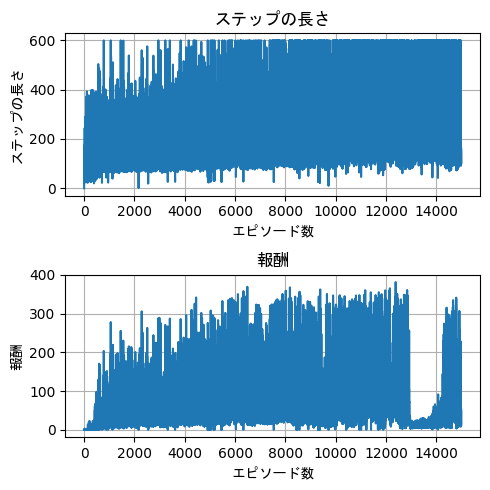

In [10]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 5))  # 図のサイズを設定

# ステップの長さのグラフ
plt.subplot(2, 1, 1)  # 2行1列のグリッドの1番目
plt.title("ステップの長さ", fontname="MS Gothic")
plt.grid()
plt.xlabel("エピソード数", fontname="MS Gothic")
plt.ylabel("ステップの長さ", fontname="MS Gothic")
t = list(range(len(env.stepcount_graph)))
plt.plot(t, env.stepcount_graph, linestyle='solid')

# 報酬のグラフ
plt.subplot(2, 1, 2)  # 2行1列のグリッドの2番目
plt.title("報酬", fontname="MS Gothic")
plt.grid()
plt.xlabel("エピソード数", fontname="MS Gothic")
plt.ylabel("報酬", fontname="MS Gothic")
t2 = list(range(len(env.epi_reward_graph)))
plt.plot(t2, env.epi_reward_graph, linestyle='solid')

plt.tight_layout()  # グラフ間のスペースを調整
plt.show()


In [ ]:
# 推論
import gymnasium as gym
from stable_baselines3 import SAC, PPO
from tqdm import trange
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo
import datetime

# env = gym.make("ALE/Breakout-v5",  render_mode="human")
# env = gym.make("CartPole-v1",  render_mode="human")
# # env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)　こんな感じで，
# model = SAC("MlpPolicy", env, verbose=1)
# model.learn(total_timesteps=200)

from stable_baselines3.common.callbacks import BaseCallback

start_time = datetime.datetime.now().replace(microsecond=0)

env = gym.make("MouseRightEnv-v0", render_mode="human")
# video_path = "./"  # 保存先のpath
# env = RecordVideo(env, video_path, video_length=500)
# env.model.opt.timestep = 0.01  # タイムステップを設定 RecordVideoする場合はそれ以降に書かないとerrorが出る

# model = PPO("MlpPolicy", env, verbose=0)
model = PPO.load('okiro',env)
# render_freq = 1000  # 1000ステップごとにレンダリング
# callback = CustomCallback(render_freq)
for i in range(100):
    # model.learn(total_timesteps=10000)#progress_bar = True, callback=callback)

    # モデルのテスト
    obs, _ = env.reset()  # ここを修正
    
    for unk in trange(60000):
        # 環境の描画
        env.render()

        # モデルの推論
        # print("本物のobs!",obs)
        action, _ = model.predict(obs)
        # print("本物のaction", action)

        # 1ステップ実行
        obs, reward, terminated, truncated, info = env.step(action) #以前の4要素のタプルから5要素のタプルに変更され，`observation, reward, terminated, truncated, info`という形式になった。
        # print(obs)


        # エピソード完了（終了または切り捨て）のチェック terminated(終了した)は目的を達成してエピソードを終了したことを表す，truncated(切り捨てられた)は，達成できずにエピソードが終了したことを表す
        if terminated or truncated:
            # print(obs)
            obs, _ = env.reset() # エピソードが終了したら、環境をリセット
    #モデルの保存 (1)
    # model.save('okiro')
    # model.save('hidarimawari_housyuu_godsight_onlyxy_notight')
    end_time = datetime.datetime.now().replace(microsecond=0)
    total_time = end_time - start_time
    # bot = LINENotifyBot(access_token='UuzEJNM69oW7g0suO2FsWygFKvSK4vj7HnEBFLyi0mc')
    # bot.send(
    # message="今"+str(i+1)+"回目の学習が終了しました\nかかった時間："+str(total_time)+"秒かかりました",
    # #image='picf' + str(i) + '.png',  # png or jpg
    # # sticker_package_id=1,
    # # sticker_id=6,
    # )

# print(video_path)
plt.title("1マス前進", fontname="MS Gothic")
plt.grid()
plt.xlabel("step(s)", fontname="MS Gothic")
plt.ylabel("速度[m/s]", fontname="MS Gothic")

#前進関係のプロット
t = list(range(len(env.reward_graph)))  # 0から始まるインデックスのリストを作成
plt.plot(t, env.reward_graph, linestyle='solid', label="報酬")
plt.legend()
# 環境のクローズ
env.close()

In [ ]:
import gymnasium as gym
from stable_baselines3 import SAC, PPO
from tqdm import trange
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo
import datetime

# env = gym.make("ALE/Breakout-v5",  render_mode="human")
# env = gym.make("CartPole-v1",  render_mode="human")
# # env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)　こんな感じで，
# model = SAC("MlpPolicy", env, verbose=1)
# model.learn(total_timesteps=200)

from stable_baselines3.common.callbacks import BaseCallback

start_time = datetime.datetime.now().replace(microsecond=0)

env = gym.make("MouseRightEnv-v0", render_mode="human")
# video_path = "./"  # 保存先のpath
# env = RecordVideo(env, video_path, video_length=500)
# env.model.opt.timestep = 0.01  # タイムステップを設定 RecordVideoする場合はそれ以降に書かないとerrorが出る

model = PPO("MlpPolicy", env, verbose=0)
# model = PPO.load('caricu_hidari',env)




import time
import matplotlib.pyplot as plt
import mujoco
import mujoco.viewer
import glfw
import keyboard
import math

def action(model, data, left, right):
    data.actuator('right').ctrl[0] = right
    data.actuator('left').ctrl[0] = left

def get_distance(model, data):
    lf = data.sensor('LF').data[0]#sensordata[lf_id]
    ls = data.sensor('LS').data[0]#sensordata[ls_id]
    rs = data.sensor('RS').data[0]#sensordata[rs_id]
    rf = data.sensor('RF').data[0]#sensordata[rf_id]
    return lf,ls,rs,rf

def get_accel(model, data):
  ax = data.sensor('Accel').data[0]
  ay = data.sensor('Accel').data[1]
  az = data.sensor('Accel').data[2]
  return ax,ay,az

def get_gyro(model, data):
  gx = data.sensor('Gyro').data[0]
  gy = data.sensor('Gyro').data[1]
  gz = data.sensor('Gyro').data[2]
  return gx,gy,gz

def get_odom(model, data): #今のタイヤの回転角度と速度（角度と角速度）を求める．
  odm_right = data.actuator('right').length[0]/gear # 得た値をgearで割ったもの＝タイヤの角度(rad)
  odm_left = data.actuator('left').length[0]/gear # ＝タイヤの角度
  vel_left = data.actuator('left').velocity[0]/gear # ＝タイヤの回転角速度
  return odm_right, odm_left

def get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left): #回転量をパルスにする エンコーダの役割をする関数
  """
    回転量の差から，パルス数を求める． エンコーダの役割をする関数\\
    Returns:
        right_pulse_num = 右タイヤのパルス数 \\
          left_pulse_num = 左タイヤのパルス数
    """
  global right_rotation_sum
  global left_rotation_sum
  pre_right_rotation_sum = right_rotation_sum
  pre_left_rotation_sum = left_rotation_sum
  right_rotation_sum += (odm_right - pre_odm_right)/(2*math.pi) *4096 #1周あたり4096段階で，細かい回転量を計測（分解能ほぼ無限のエンコーダ）
  left_rotation_sum += (odm_left - pre_odm_left)/(2*math.pi) *4096 #1周あたり4096段階で，細かい回転量を計測（分解能ほぼ無限のエンコーダ）
  right_pulse_num = int(right_rotation_sum) - int(pre_right_rotation_sum)
  left_pulse_num = int(left_rotation_sum) - int(pre_left_rotation_sum)
  # print("回転量をパルス段階に変換　この値の差が，実際に出たパルスとなる：", right_pulse_num)
  return right_pulse_num, left_pulse_num

def get_odom_at_pulse(right_pulse_num, left_pulse_num): #今のタイヤの回転角度と速度（角度と角速度）を求める．
  right_wheel_move = 2*math.pi * wheel_r * (right_pulse_num/4096) #２πｒ×回転数で移動距離を求める．/delta_t
  left_wheel_move = 2*math.pi * wheel_r * (left_pulse_num/4096) #２πｒ×回転数で移動距離を求める．
  right_wheel_vel = right_wheel_move/delta_t #移動距離から，速度を求める
  left_wheel_vel = left_wheel_move/delta_t #移動距離から，速度を求める
  mouse_vel = (right_wheel_vel + left_wheel_vel)/2 #左右平均が並進速度
  mouse_radvel = (right_wheel_vel - left_wheel_vel)/tread #これがマウスの旋回角速度（rad/s）
  return mouse_vel, mouse_radvel #これで，エンコーダによる各タイヤの推定速度が求められた



paused = False
def key_callback(keycode): #スペースキーで一時停止
  if chr(keycode) == ' ':
    global paused #グローバル変数のpausedを使用できるように，この関数のスコープ内に取り込む処理
    paused = not paused #pausedの真偽値を逆にする　trueとfalseを反転


# def P_straight_control(model, data):#左右の壁による位置補正
#     now_speed_left = data.actuator('left').ctrl[0]
#     now_speed_right = data.actuator('right').ctrl[0]
#     lf, ls, rs, rf = get_distance(model, data)
    
#     sensor_diff = ls - rs # 目標値との誤差 正の値のときは，右に寄っている→左を下げて，右を早めたい
#     # print(sensor_diff)
#     left_mot = kp * -sensor_diff + 0.2
#     right_mot = kp * sensor_diff + 0.2
#     global turn_flag
#     if turn_flag==1 or (lf<0.07 and rf <0.07):
#         turn_flag = 1
#         right_mot =  0.06
#         left_mot  = -0.06
#         if lf > 0.09 and rf > 0.09:
#           turn_flag = 0
#     return left_mot, right_mot

#関数化で新しく作成した関数

def mj_step_loop(model, data, loop_num): #mujocoのシミュレーションを任意の数だけ行う関数 グラフ化するときに不便かもしれないから不必要かも
  for i in range(loop_num):
    action(model, data, left_mot, right_mot)#なくても変わらない？？
    mujoco.mj_step(model, data)
    timevals.append(data.time)
    #Vizualize
    viz_now = data.time
    if viz_now-viz_past>0.01:
      viz_past = viz_now
      viewer.sync()

def straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=16.9, ki=1,):#前進0.5マス
  #最初の前進
  straight_kp = kp #デフォルトのゲインにして，変更があったらそれを使う
  straight_ki = ki
  
  I_err_sum = 0 #これは関数ごとでいいのか，引数と戻り値にして引き継いでいくべきなのか？
  target_vel = 0
  past_time = data.time
  # mouse_xpos = 0 #globalにして，引数で受け取ったものに足して言って，戻り値として座標を返すようにすべき？？
  # mouse_ypos = 0
  viz_past = 0 #globalにすべき??
  # エンコーダを読み取る
  pre_odm_right, pre_odm_left = get_odom(model, data)
  for kagennsoku in range(3):
    target_add_num = [0.15,0,-0.15] #各区間での目標速度を入れておくリスト
    print("目標速度：",target_add_num[kagennsoku], "＃＃＃＃＃＃＃＃")
    for mokuhyou_zahyou_kousin in range(30):
      target_vel += target_add_num[kagennsoku]/30 #0から始まって，
      err_vel = target_vel - mouse_vel # 目標との速度誤差を計算
      # print("原因説err_vel：", err_vel)
      I_err_sum += err_vel
      left_mot = straight_kp * err_vel + straight_ki * I_err_sum
      right_mot = straight_kp * err_vel + straight_ki * I_err_sum
      action(model, data, left_mot, right_mot)
      # 制御周期を遅くするため，シミュレーションを100回繰り返す
      for seigyosyuuki_delay in range(100):
        mujoco.mj_step(model, data)#################################################################
        # lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得
      #Vizualize　あんまり細かく描画しすぎないように，0.01秒以上経ってたら描画するようにする
      viz_now = data.time
      if viz_now-viz_past>0.1:
        viz_past = viz_now
        viewer.sync()
      
      now_time = data.time
      delta_t = now_time - past_time #シミュレーションが1ステップ終わった後の時間を取得
      past_time = now_time
      # エンコーダをもう一度読み取る　（行動後の値を取得）
      odm_right, odm_left = get_odom(model, data)
      # エンコーダ値から，この一瞬に出たパルス数を算出し，
      right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      right_pulse_num_graph.append(right_pulse_num)
      # パルス数から，移動速度と角速度を求める
      mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      mouse_angle_rad += mouse_rad_vel * delta_t #マウスの角速度はパルスの左右差で求められるので，現在の角度は
      # print("関数内は：", mouse_angle_rad)
      mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t #オドメトリで座標推定
      mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      # 一つ前のodom値を更新
      pre_odm_right = odm_right
      pre_odm_left = odm_left 
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()

  return model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left

def right_curve(model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0,):
  r_turn_kp = kp
  r_turn_ki = ki
  # エンコーダを読み取る
  pre_odm_right, pre_odm_left = get_odom(model, data)
  target_rad_vel = 0
  I_err_rad_vel_sum = 0 #これは関数ごとでいいのか，引数と戻り値にして引き継いでいくべきなのか？
  past_time = data.time
  viz_past = 0 #globalにすべき??
  for kasoku in range(3):
    target_add_rad_vel = [(math.pi*5/6),0,(-math.pi*5/6)]
    print(target_add_rad_vel[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
    for kukan in range(30):
      target_rad_vel += target_add_rad_vel[kasoku]/30 #目標回転角速度を15度/秒にすると
      err_rad_vel = target_rad_vel - mouse_rad_vel # 目標との角速度誤差を計算
      I_err_rad_vel_sum += err_rad_vel # 目標との角速度誤差を積算
      left_mot = -r_turn_kp * err_rad_vel - r_turn_ki * I_err_rad_vel_sum
      right_mot = r_turn_kp * err_rad_vel + r_turn_ki * I_err_rad_vel_sum
      action(model, data, left_mot, right_mot)
      for seigyosyuuki in range(100):
        mujoco.mj_step(model, data)
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
      now_time = data.time
      delta_t = now_time - past_time
      past_time = now_time
      # エンコーダをもう一度読み取る
      odm_right, odm_left = get_odom(model, data)
      # この一瞬に出たパルス数を算出し，
      right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      right_pulse_num_graph.append(right_pulse_num)
      # パルス数から，移動速度と角速度を求める
      mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      # mouse_vel_graph.append(mouse_vel)
      # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      mouse_angle_rad += mouse_rad_vel * delta_t
      mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
      mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      mouse_xpos_graph.append(mouse_xpos)
      mouse_ypos_graph.append(mouse_ypos)
      # 一つ前のodom値を更新
      pre_odm_right = odm_right
      pre_odm_left = odm_left
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()

  return model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left


def left_curve(model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0,):
  r_turn_kp = kp
  r_turn_ki = ki
  # エンコーダを読み取る
  pre_odm_right, pre_odm_left = get_odom(model, data)
  target_rad_vel = 0
  I_err_rad_vel_sum = 0 #これは関数ごとでいいのか，引数と戻り値にして引き継いでいくべきなのか？
  past_time = data.time
  viz_past = 0 #globalにすべき??
  for kasoku in range(3):
    target_add_rad_vel = [(-math.pi*5/6),0,(math.pi*5/6)]
    print(target_add_rad_vel[kasoku], "＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃＃")
    for kukan in range(30):
      target_rad_vel += target_add_rad_vel[kasoku]/30 #目標回転角速度を15度/秒にすると
      err_rad_vel = target_rad_vel - mouse_rad_vel # 目標との角速度誤差を計算
      I_err_rad_vel_sum += err_rad_vel # 目標との角速度誤差を積算
      left_mot = -r_turn_kp * err_rad_vel - r_turn_ki * I_err_rad_vel_sum
      right_mot = r_turn_kp * err_rad_vel + r_turn_ki * I_err_rad_vel_sum
      action(model, data, left_mot, right_mot)
      for seigyosyuuki in range(100):
        mujoco.mj_step(model, data)
      #Vizualize
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()
      now_time = data.time
      delta_t = now_time - past_time
      past_time = now_time
      # エンコーダをもう一度読み取る
      odm_right, odm_left = get_odom(model, data)
      # この一瞬に出たパルス数を算出し，
      right_pulse_num, left_pulse_num = get_pulse_count(pre_odm_right, pre_odm_left, odm_right, odm_left)
      right_pulse_num_graph.append(right_pulse_num)
      # パルス数から，移動速度と角速度を求める
      mouse_vel, mouse_rad_vel = get_odom_at_pulse(right_pulse_num, left_pulse_num) #これで，エンコーダによるマウスの速度・角速度が推定できた
      # mouse_vel_graph.append(mouse_vel)
      # 速度に時間を掛けて，移動距離を計算 まず向きを計算し，その後移動距離を求める
      mouse_angle_rad += mouse_rad_vel * delta_t
      mouse_xpos += mouse_vel * math.cos(mouse_angle_rad) * delta_t
      mouse_ypos += mouse_vel * math.sin(mouse_angle_rad) * delta_t
      mouse_xpos_graph.append(mouse_xpos)
      mouse_ypos_graph.append(mouse_ypos)
      # 一つ前のodom値を更新
      pre_odm_right = odm_right
      pre_odm_left = odm_left
      viz_now = data.time
      if viz_now-viz_past>0.01:
        viz_past = viz_now
        viewer.sync()

  return model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left






#Create model
# model = mujoco.MjModel.from_xml_path('../mouse_in_maze.xml')
# data = mujoco.MjData(model)
model = env.model
data = env.data

odom_right_graph = []
mouse_correct_vel_graph = []

gear = 9.0e-3
wheel_r = 0.0135
tread = 0.072
mx = 0.0
my = 0.0
psi = 0.0
past_odom_right = 0.0
past_odom_left = 0.0
# kp = 100
# st_Kp = 1.55 #ダンピング3.6e-6のときの最適なゲイン
st_Kp = 8.4
rad_Kp = 0.15
rad_vel_Kp = 2

rad_Kd = 0.00001

ki6 = 0.02
kd = 0.09
I_err_sum = 0
d_grad = 0
prev_err_rad = 0
target_vel = 0
target_rad = math.pi/2
target_rad_vel = 0
mjstep_count = 0

right_pulse_num = 0
right_pulse_num_graph = []
left_pulse_num = 0
left_pulse_num_graph = []

right_rotation_sum = 0
left_rotation_sum = 0

mouse_vel = 0
mouse_rad_vel = 0
mouse_xpos = 0
mouse_xpos_graph = []
mouse_ypos = 0
mouse_ypos_graph = []
target_vel_graph = []
err_vel_graph = []
mouse_vel_graph = []

viz_now = 0.0
viz_past = 0.0
now_time = 0
past_time = 0
turn_flag = 0
x_vel = 0
y_vel = 0
z_vel = 0
err = 0
delta_t = 0.01
mouse_now_rad_xy = math.pi/2 #y軸方向を向いている
I_err_rad_vel_sum = 0
mouse_angle_rad = (math.pi/2)
right_mot = 0
left_mot = 0 #最初は0

#デバッグ用グラフのためのリスト
LRF_lf_graph = []
LRF_ls_graph = []
LRF_rs_graph = []
LRF_rf_graph = []
left_mot_graph = []
x_vel_graph = []
velocimeter_graph = []
err_graph = []
err_rad_graph = []
gyro_graph = []
yzahyou = []
timevals = []
timevals5 = []
timevals6 = []
mouse_angle_rad_graph = []
mouse_correct_rad_vel_graph = []
mouse_rad_vel_graph = []
err_rad_vel_graph = []
target_rad_vel_graph = []

with mujoco.viewer.launch_passive(model, data, key_callback=key_callback) as viewer: #キーイベントが発生すると、登録されたコールバック関数であるkey_callbackが自動的に呼び出され、キーコードやその他のイベント情報が引数keycodeとして渡されます。
  # 最初の準備 わずかに浮いているせいで最初だけ推測速度が大きくなるので，一度地面につかせる
  time.sleep(3) #3秒待ってからスタート ウインドウを出すために待ってもらう
  left_mot = 0
  right_mot = 0
  for seigyosyuuki2 in range(1000): #マウスを地面につけるために，100回シミュレーションを回す　空中でタイヤを回し始めないようにするため
    action(model, data, left_mot, right_mot)
    mujoco.mj_step(model, data)
  past_time = data.time #最初の時間を取得
  print("最初の１マス進む処理")
  target_vel = 0
  pre_odm_right, pre_odm_left = get_odom(model, data)# エンコーダを読み取る
  model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=4.9, ki=0,) #最初の前進
  
  while viewer.is_running():
    
    if not paused:
      before_ax, before_ay, before_az = get_accel(model, data)
      gx, gy, gz = get_gyro(model, data)
      lf, ls, rs, rf = get_distance(model, data) #各センサ値を取得
      

      if ls > 0.09:
        print("左に壁がないとき")
        # pre_odm_right, pre_odm_left = get_odom(model, data)# エンコーダを読み取る
        model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = straight(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=4.9, ki=0,) #0.5マス前進
        print("xpos:",mouse_xpos)
        print("ypos:",mouse_ypos)
        model, data, mouse_xpos, mouse_ypos, mouse_rad_vel, mouse_angle_rad, pre_odm_right, pre_odm_left = right_curve(model, data, mouse_xpos, mouse_ypos, mouse_vel, mouse_angle_rad, pre_odm_right, pre_odm_left, kp=0.57, ki=0.05,) #右にカーブ
        print("xpos:",mouse_xpos)
        print("ypos:",mouse_ypos)

In [ ]:
def RLaction(obs, model):
    import gymnasium as gym
    from stable_baselines3 import SAC, PPO
    from tqdm import trange
    import matplotlib.pyplot as plt
    from gymnasium.wrappers import RecordVideo
    import datetime

    # env = gym.make("ALE/Breakout-v5",  render_mode="human")
    # env = gym.make("CartPole-v1",  render_mode="human")
    # # env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)　こんな感じで，
    # model = SAC("MlpPolicy", env, verbose=1)
    # model.learn(total_timesteps=200)

    from stable_baselines3.common.callbacks import BaseCallback

    start_time = datetime.datetime.now().replace(microsecond=0)

    env = gym.make("MouseRightEnv-v0", render_mode="human")
    # video_path = "./"  # 保存先のpath
    # env = RecordVideo(env, video_path, video_length=500)
    env.model.opt.timestep = 0.01  # タイムステップを設定 RecordVideoする場合はそれ以降に書かないとerrorが出る

    # model = PPO("MlpPolicy", env, verbose=0)
    model = PPO.load('caricu_hidari',env)
    # render_freq = 1000  # 1000ステップごとにレンダリング
    # callback = CustomCallback(render_freq)
    for i in range(200):
        model.learn(total_timesteps=10000)#progress_bar = True, callback=callback)

        for unk in trange(1000):
            # 環境の描画
            env.render()

            # モデルの推論
            action, _ = model.predict(obs)
            obs, _, _, _  = env.step(action)
    return obs

In [ ]:
import gymnasium as gym
from stable_baselines3 import SAC, PPO
from tqdm import trange
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo
import datetime

# env = gym.make("ALE/Breakout-v5",  render_mode="human")
# env = gym.make("CartPole-v1",  render_mode="human")
# # env = Monitor(env, "./gym-results", force=True, video_callable=lambda episode: True)　こんな感じで，
# model = SAC("MlpPolicy", env, verbose=1)
# model.learn(total_timesteps=200)

from stable_baselines3.common.callbacks import BaseCallback

start_time = datetime.datetime.now().replace(microsecond=0)

env = gym.make("MouseRightEnv-v0", render_mode="human")
# video_path = "./"  # 保存先のpath
# env = RecordVideo(env, video_path, video_length=500)
env.model.opt.timestep = 0.01  # タイムステップを設定 RecordVideoする場合はそれ以降に書かないとerrorが出る

# model = PPO("MlpPolicy", env, verbose=1)
model = PPO.load('hidarimawari_housyuu',env)
# render_freq = 1000  # 1000ステップごとにレンダリング
# callback = CustomCallback(render_freq)
for i in range(100):
    # model.learn(total_timesteps=10000)#progress_bar = True, callback=callback)

    # モデルのテスト
    obs, _ = env.reset()  # ここを修正
    for unk in trange(1000):
        # 環境の描画
        env.render()

        # モデルの推論
        action, _ = model.predict(obs)
        print(action)
        action = [0.1, 0.1]

        # 1ステップ実行
        obs, reward, terminated, truncated, info = env.step(action) #以前の4要素のタプルから5要素のタプルに変更され，`observation, reward, terminated, truncated, info`という形式になった。

        # エピソード完了（終了または切り捨て）のチェック terminated(終了した)は目的を達成してエピソードを終了したことを表す，truncated(切り捨てられた)は，達成できずにエピソードが終了したことを表す
        if terminated or truncated:
            obs, _ = env.reset() # エピソードが終了したら、環境をリセット
    #モデルの保存 (1)
    # model.save('4sensaonly_rl')
    # model.save('hidarimawari_housyuu')
    end_time = datetime.datetime.now().replace(microsecond=0)
    total_time = end_time - start_time
    bot = LINENotifyBot(access_token='UuzEJNM69oW7g0suO2FsWygFKvSK4vj7HnEBFLyi0mc')
    bot.send(
    message="今"+str(i+1)+"回目の学習が終了しました\nかかった時間："+str(total_time)+"秒かかりました",
    #image='picf' + str(i) + '.png',  # png or jpg
    # sticker_package_id=1,
    # sticker_id=6,
    )

# print(video_path)
plt.title("1マス前進", fontname="MS Gothic")
plt.grid()
plt.xlabel("step(s)", fontname="MS Gothic")
plt.ylabel("速度[m/s]", fontname="MS Gothic")

#前進関係のプロット
t = list(range(len(env.reward_graph)))  # 0から始まるインデックスのリストを作成
plt.plot(t, env.reward_graph, linestyle='solid', label="報酬")
plt.legend()
# 環境のクローズ
env.close()

In [ ]:
# print(video_path)
plt.title("1マス前進", fontname="MS Gothic")
plt.grid()
plt.xlabel("step(s)", fontname="MS Gothic")
plt.ylabel("速度[m/s]", fontname="MS Gothic")

#前進関係のプロット
t = list(range(len(env.reward_graph)))  # 0から始まるインデックスのリストを作成
plt.plot(t, env.reward_graph, linestyle='solid', label="報酬")
plt.legend()

In [ ]:
plt.title("オドメトリ", fontname="MS Gothic")
plt.grid()
plt.xlabel("x座標[m]", fontname="MS Gothic")
plt.ylabel("y座標[m]", fontname="MS Gothic")
plt.plot(env.mouse_ypos_graph, env.mouse_xpos_graph, linestyle='solid', label="報酬")

In [ ]:
import gymnasium as gym
from stable_baselines3 import SAC, PPO
from tqdm import trange
import matplotlib.pyplot as plt
from gymnasium.wrappers import RecordVideo

import datetime
from stable_baselines3.common.callbacks import BaseCallback

start_time = datetime.datetime.now().replace(microsecond=0)

env = gym.make("MouseEnv-v0", render_mode="human")
env.model.opt.timestep = 0.01  # タイムステップを設定 RecordVideoする場合はそれ以降に書かないとerrorが出る

# model = PPO("MlpPolicy", env, verbose=1)
model = PPO.load('PPO',env)
for i in range(3):
    # モデルのテスト
    state, _ = env.reset()  # ここを修正
    for i in trange(100):
        # 環境の描画
        env.render()

        # モデルの推論
        action, _ = model.predict(state)

        # 1ステップ実行
        obs, reward, terminated, truncated, info = env.step(action) #以前の4要素のタプルから5要素のタプルに変更され，`observation, reward, terminated, truncated, info`という形式になった。
        # エピソード完了（終了または切り捨て）のチェック terminated(終了した)は目的を達成してエピソードを終了したことを表す，truncated(切り捨てられた)は，達成できずにエピソードが終了したことを表す
        if terminated or truncated:
            state, _ = env.reset() # エピソードが終了したら、環境をリセット
# 環境のクローズ
env.close()

In [ ]:
import gymnasium as gym
env = gym.make('CartPole-v1')
print(env.metadata)


## env.step(action)の戻り値の更新について（４つから５つになりました）
Gymライブラリのバージョン0.26以降、及びGymnasiumの全バージョンにおいて、`env.step()`メソッドの戻り値は、以前の4要素のタプルから5要素のタプルに変更されました。これまでの`observation, reward, done, info`という形式から、`observation, reward, terminated, truncated, info`という形式になっています。

ここでの`terminated`と`truncated`はどちらもブール値（真偽値）です。`terminated`は環境がマルコフ決定過程（MDP）のタスクの定義に基づいて終了状態に達したことを示します。これは通常、環境の目標が達成されたり、終了条件が満たされたときに発生します。一方、`truncated`は、エピソードがMDPの範囲外の条件、たとえば時間制限や境界条件（エージェントが境界を越えるなど）によって終了したことを示します。強化学習アルゴリズムにおいて、特にブートストラップを伴うものでは、終了と切り捨て状態の取り扱いが値の更新において異なる場合があるため、この区別は重要です。

Gymライブラリのこの更新は、強化学習タスクにおける終了と切り捨ての明確な区別を提供するために行われました。これは、特定のアルゴリズムの正確な実装にとって重要です。終了(`terminated`)と切り捨て(`truncated`)の両方のタイプのエピソード終了を区別するために、両方が含まれるようになりました。

あなたの目的に合わせて、エピソードが終了したかどうか（理由に関係なく）を知りたい場合は、`terminated`または`truncated`のいずれかが`True`であるかどうかを確認すればよいです。その場合、環境をリセットします。

In [ ]:
# モデルのテスト
state, _ = env.reset()  # ここを修正
for i in trange(4000):
    # 環境の描画
    env.render()

    # モデルの推論
    action, _ = model.predict(state)

    # 1ステップ実行
    state, rewards, done, info = env.step(action)

    # エピソード完了
    if done:
        state, _ = env.reset()  # エピソードが終了したら、環境をリセット
